# Example of the usage of the Weak label classifier

We first need to load:

1. **Standard Python libraries** for data handling and reproducibility.  
2. **PyTorch** (and its submodules) for model definition, training, and data loading.  
3. **Custom modules** from this project:
   - **`train_test_loop`**: provides the `train_and_evaluate` function to run training and evaluation loops.  
   - **`losses`**: contains various weak‐label‐aware loss functions like `FwdBwdLoss`.  
   - **`weakener`**: implements the `Weakener` class for generating noisy/weak labels.  
   - **`model`**: defines model architectures .
   - **`dataset`**: provides `Data_handling` (and other dataset classes) for loading and splitting data.  


In [ ]:
# Standard libraries
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# PyTorch core
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Custom project modules
from utils.train_test_loop import train_and_evaluate
from utils.losses import FwdBwdLoss, MarginalChainLoss
from utils.losses1 import MarginalChainProperLoss, ForwardProperLoss, scoring_matrix
from utils.dataset_visualization import visualize_dataset
from src.weakener import Weakener
from src.model import MLP
from src.dataset import Data_handling


# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Loading and Visualizing Iris

1. **Instantiate** our `Data_handling` class to load the Iris dataset from OpenML (ID 61) using an 80/20 train/test split.  
2. **Retrieve** the raw arrays of features and labels via `get_data()`.  
3. **Combine** the train and test portions back into a single DataFrame 
4. **Visualize** 

In [2]:
Data = Data_handling(
    dataset='mnist',
    train_size=0.8,
    test_size=0.2,
    batch_size=64,
    shuffling=False,
    splitting_seed=42
)

In [3]:
Data.train_dataset.data # This is Train_X
Data.train_dataset.targets # This is Train_y
print(Data.test_dataset.targets)
df = pd.DataFrame(Data.train_dataset.data.numpy(), columns=[f'feature_{i}' for i in range(Data.train_dataset.data.shape[1])])
df['target'] = [i for i in Data.train_dataset.targets.numpy()]
df


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_775,feature_776,feature_777,feature_778,feature_779,feature_780,feature_781,feature_782,feature_783,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
59996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
59997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
59998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."


In [4]:
Data.num_classes

10

KeyboardInterrupt: 

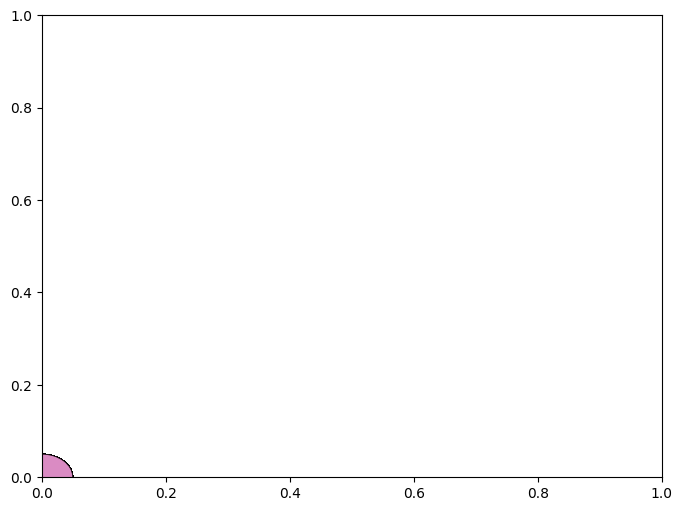

In [19]:
visualize_dataset(
    df,
    features=['feature_0', 'feature_1'],
    classes=Data.num_classes,
    title='GMM Samples Visualization',
)


Next, we’ll simulate a **partial‐label learning** or **noisy-label** setting by corrupting each true label with **M**:

1. **Instantiate** a `Weakener` with the number of true classes.  
2. **Build** a mixing matrix via `generate_M(model_class='pll', corr_p=…)` 
3. **Generate** weak labels with `generate_weak`, which returns:
   - `z`: the integer index of the weak‐label   
   - `w`: a binary matrix of shape `(n_samples, n_classes)` indicating the candidate labels  
4. **Insert** the partial labels into our Data using `include_weak(w)`.  

In [5]:
corr_p = 0.2
weakener = Weakener(true_classes=Data.num_classes)
weakener.generate_M(model_class='pll', corr_p=0.2)
# weakener.generate_M(model_class='unif_noise', corr_p=0.5) #Try this for noisy labels
print(f"Generated M matrix:\n{weakener.M}")
true_onehot = Data.train_dataset.targets  # shape: (n_samples, n_classes)

z, w = weakener.generate_weak(true_onehot)
print(f"Generated z (noisy labels):\n{z}")
print(f"Generated w (multi-label matrix):\n{w}")

Data.include_weak(z)

train_loader, test_loader = Data.get_dataloader(weak_labels='weak')

batch = next(iter(train_loader))
xb, wb, yb = batch
print(f"Inputs batch shape: {xb.shape}")
print(f"Weak (partial) labels shape: {wb.shape}")
print(f"True one-hot labels shape: {yb.shape}")

Generated M matrix:
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.34217728e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.34217728e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  3.35544320e-02 3.35544320e-02]
 ...
 [2.04800000e-06 2.04800000e-06 2.04800000e-06 ... 2.04800000e-06
  0.00000000e+00 2.04800000e-06]
 [2.04800000e-06 2.04800000e-06 2.04800000e-06 ... 2.04800000e-06
  2.04800000e-06 0.00000000e+00]
 [5.12000000e-07 5.12000000e-07 5.12000000e-07 ... 5.12000000e-07
  5.12000000e-07 5.12000000e-07]]
Generated z (noisy labels):
tensor([ 49, 848, 304,  ...,  25,  59, 129], dtype=torch.int32)
Generated w (multi-label matrix):
tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [1., 1., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 1., 0.]], 

In [7]:
weak_df = pd.DataFrame(Data.train_dataset.data.numpy(), columns=[f'feature_{i}' for i in range(Data.train_dataset.data.shape[1])])
df['target'] = [i for i in weakener.w.numpy()]
df

,feature_0,feature_1,feature_2,feature_3,target
0,5.0,3.4,1.6,0.4,"[1.0, 0.0, 0.0]"
1,6.3,3.3,4.7,1.6,"[1.0, 1.0, 0.0]"
2,5.1,3.4,1.5,0.2,"[1.0, 0.0, 1.0]"
3,4.8,3.0,1.4,0.1,"[1.0, 0.0, 0.0]"
4,6.7,3.1,4.7,1.5,"[0.0, 1.0, 0.0]"
...,...,...,...,...,...
115,5.5,4.2,1.4,0.2,"[1.0, 1.0, 0.0]"
116,6.8,3.0,5.5,2.1,"[1.0, 0.0, 1.0]"
117,5.1,3.8,1.5,0.3,"[1.0, 0.0, 0.0]"
118,6.0,2.7,5.1,1.6,"[1.0, 1.0, 0.0]"


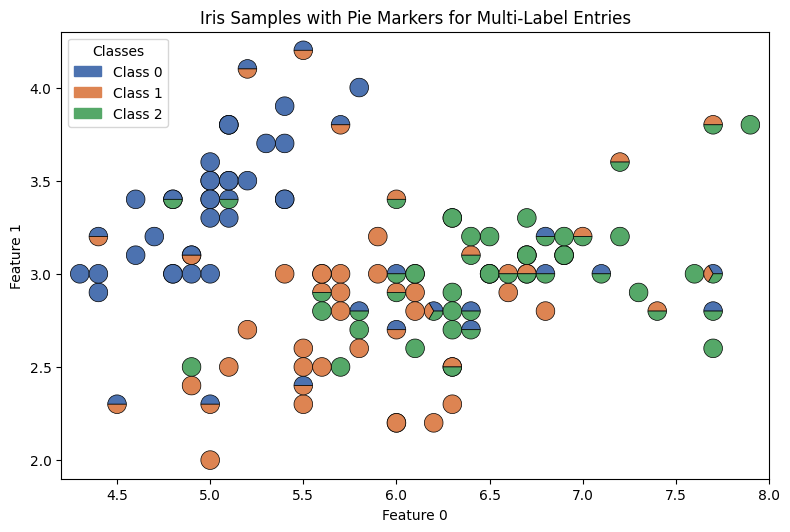

In [8]:
visualize_dataset(
    df,
    features=['feature_0', 'feature_1'],
    classes=3,
    title='Iris Samples with Pie Markers for Multi-Label Entries'
)



1. **Instantiate** the model (e.g. `MLP`) with its input/output dimensions.   
2. **Choose** the optimizer and set hyperparameters.  
3. **Define** the loss function.

We also could do a learning rate scheduler (e.g. `StepLR`) to decrease the LR over time. 

## Training the MLP (using `train_test_loop.py`)

1. **Set** training hyperparameters  
2. **Call** `train_and_evaluate(model, train_loader, test_loader, optimizer, pll_loss, num_epochs, corr_p)`
3. **Plot** results

Using device: cuda
Epoch 10/30: Train Loss: 0.0000, Train Acc: 0.3761, Test Acc: 0.3768, Train Detached Loss: 642.9482, Test Detached Loss: 653.4801, Learning Rate: 0.100000, Epoch Time: 4.41 seconds
Epoch 20/30: Train Loss: 0.0000, Train Acc: 0.3761, Test Acc: 0.3768, Train Detached Loss: 642.9480, Test Detached Loss: 653.4760, Learning Rate: 0.100000, Epoch Time: 4.81 seconds
Epoch 30/30: Train Loss: 0.0000, Train Acc: 0.3761, Test Acc: 0.3768, Train Detached Loss: 642.8993, Test Detached Loss: 653.4260, Learning Rate: 0.100000, Epoch Time: 4.61 seconds
    epoch    train_loss  train_acc  test_acc  train_detached_loss  \
0       1  7.055226e-05   0.256800    0.2654           345.764401   
1       2  1.925582e-05   0.258883    0.2106           602.180771   
2       3  2.190161e-05   0.304883    0.3443           565.204721   
3       4  3.889750e-06   0.347283    0.3559           447.749237   
4       5  5.817600e-06   0.314867    0.2805           694.287857   
5       6  1.319273e-05 

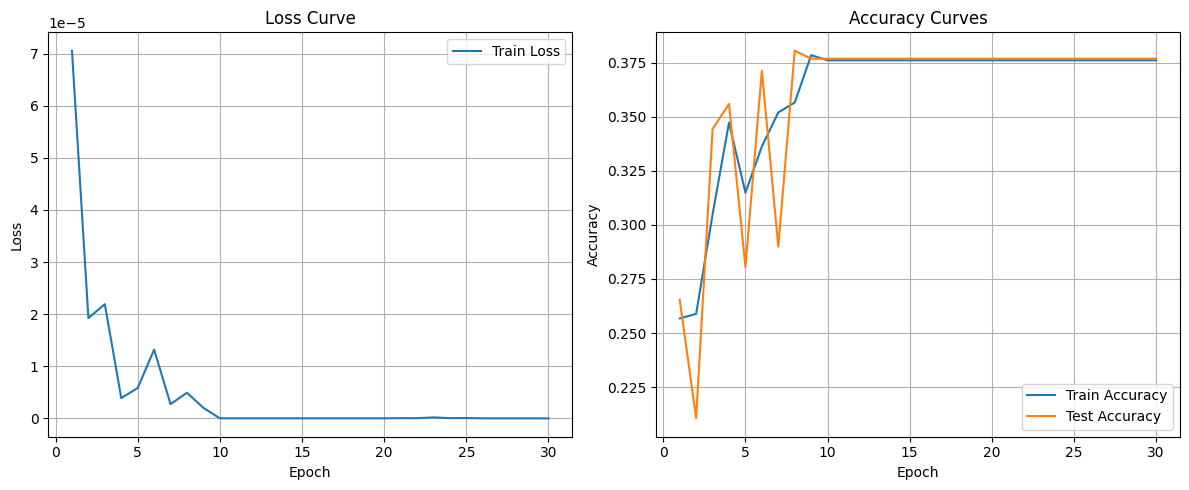

In [24]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='id'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-1,
)
# 2. Training parameters
num_epochs = 30

em_loss = MarginalChainProperLoss(weakener.M, loss_code="cross_entropy")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


Using device: cuda
Epoch 10/30: Train Loss: 0.0359, Train Acc: 0.1033, Test Acc: 0.0892, Train Detached Loss: 0.0361, Test Detached Loss: 0.0363, Learning Rate: 0.001000, Epoch Time: 4.27 seconds
Epoch 20/30: Train Loss: 0.0359, Train Acc: 0.1033, Test Acc: 0.0892, Train Detached Loss: 0.0361, Test Detached Loss: 0.0363, Learning Rate: 0.001000, Epoch Time: 4.15 seconds
Epoch 30/30: Train Loss: 0.0359, Train Acc: 0.1033, Test Acc: 0.0892, Train Detached Loss: 0.0361, Test Detached Loss: 0.0363, Learning Rate: 0.001000, Epoch Time: 5.94 seconds
    epoch  train_loss  train_acc  test_acc  train_detached_loss  \
0       1    0.035929   0.103533    0.0892             0.036115   
1       2    0.035933   0.103250    0.0892             0.036115   
2       3    0.035933   0.103250    0.0892             0.036115   
3       4    0.035933   0.103250    0.0892             0.036115   
4       5    0.035933   0.103250    0.0892             0.036115   
5       6    0.035933   0.103250    0.0892      

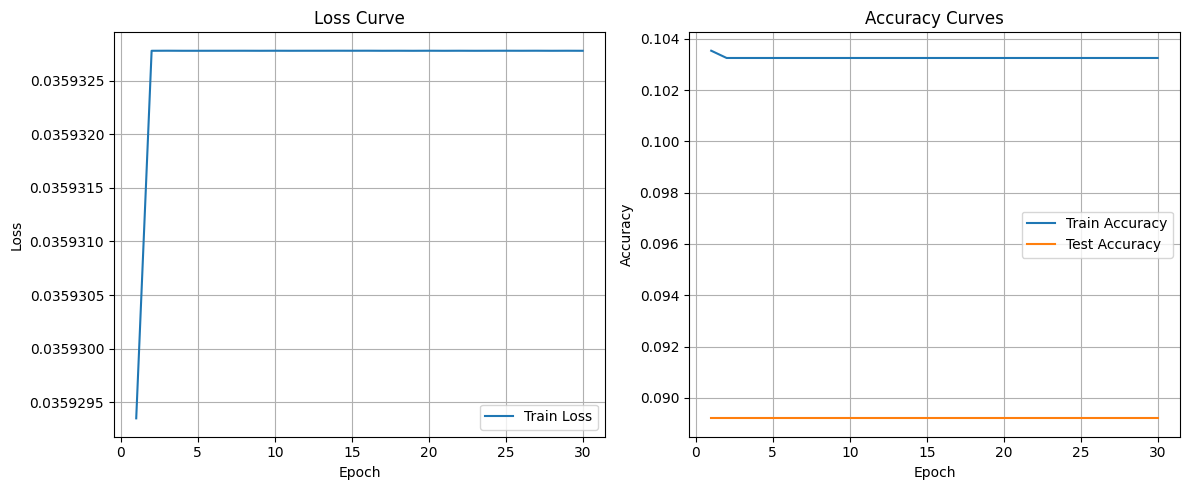

In [10]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[784, 256],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='tanh'
)

optimizer = optim.Adamax(
    model.parameters(),
    lr=1e-3,
)
# 2. Training parameters
num_epochs = 30

em_loss = MarginalChainProperLoss(weakener.M, loss_code="cross_entropy")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Using device: cuda
Epoch 10/30: Train Loss: -0.0044, Train Acc: 0.1023, Test Acc: 0.1010, Train Detached Loss: 225.4153, Test Detached Loss: 232.0057, Learning Rate: 0.100000, Epoch Time: 5.67 seconds
Epoch 20/30: Train Loss: -0.0044, Train Acc: 0.1023, Test Acc: 0.1010, Train Detached Loss: 225.4153, Test Detached Loss: 232.0057, Learning Rate: 0.100000, Epoch Time: 5.44 seconds
Epoch 30/30: Train Loss: -0.0044, Train Acc: 0.1023, Test Acc: 0.1010, Train Detached Loss: 225.4153, Test Detached Loss: 232.0057, Learning Rate: 0.100000, Epoch Time: 10.73 seconds
    epoch  train_loss  train_acc  test_acc  train_detached_loss  \
0       1   -0.004626   0.119150     0.101           225.415326   
1       2   -0.004424   0.102267     0.101           225.415326   
2       3   -0.004424   0.102267     0.101           225.415326   
3       4   -0.004424   0.102267     0.101           225.415326   
4       5   -0.004424   0.102267     0.101           225.415326   
5       6   -0.004424   0.102267

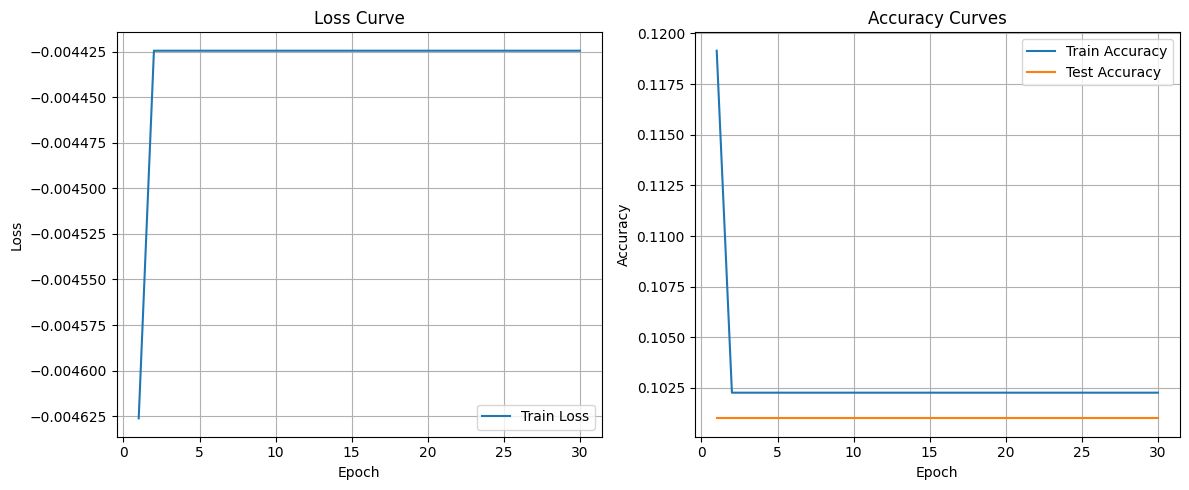

In [25]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='id'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-1,
)
# 2. Training parameters
num_epochs = 30

em_loss = MarginalChainProperLoss(weakener.M, loss_code="spherical")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
clean_indices = Data.train_dataset.targets.argmax(dim=1)  


Data.include_weak(clean_indices)

train_loader, test_loader = Data.get_dataloader(weak_labels='weak')


clean_loss =  FwdBwdLoss(np.eye(weakener.c), np.eye(weakener.c)) 


model_clean = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='id'
)

optimizer_clean = optim.Adam(
    model_clean.parameters(),
    lr=5e-2,
)


num_epochs = 30
model_clean, clean_results = train_and_evaluate(
    model_clean,     
    train_loader,    
    test_loader,     
    optimizer_clean, 
    clean_loss,      
    num_epochs,
    corr_p=0           
)


print(clean_results)


In [ ]:
# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Weak Train Loss')
ax1.plot(clean_results['epoch'], clean_results['train_loss'], label='Supervised Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Weak Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Weak Test Accuracy')
ax2.plot(clean_results['epoch'], clean_results['train_acc'],'--', label='Supervised Train Accuracy' )
ax2.plot(clean_results['epoch'], clean_results['test_acc'], '--', label='Supervied Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()